# Calibrated Equal Odds

This tutorial demostrates how apply Odds-Equalizing post-processing algorithm for bias mitigation. 

In [1]:
# sys path
import sys
sys.path.append('../../../')

# Imports
from utils import load_preprocessed_adult
from holisticai.metrics.bias import classification_bias_metrics
from holisticai.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

Load preprocessed adult dataset (details in preprocessing_dataset.ipynb)
- protected attributes: ["sex" , "race"] (attributes removed from original dataset)
- sensible attribute: "sex" (groups: "Male" and "Female")

In [2]:
train_data , test_data = load_preprocessed_adult()

Baseline

In [3]:
x, y, group_a, group_b = train_data

scaler = StandardScaler()
xt = scaler.fit_transform(x)

model = LogisticRegression()
model.fit(xt,y)

LogisticRegression()

In [4]:
x, y, group_a, group_b = test_data
xt = scaler.transform(x)

y_pred = model.predict(xt)
classification_bias_metrics(group_a, group_b, y_pred, y, metric_type='equal_opportunity')

,Value,Reference
Metric,,
Equality of Opportunity Difference,-0.059581,0
False Positive Rate Difference,-0.082695,0
Average Odds Difference,-0.071138,0
Accuracy Difference,0.122388,0


In [5]:
from holisticai.mitigation.bias import CalibratedEqualizedOdds

y_proba = model.predict_proba(xt)

bm = CalibratedEqualizedOdds('fnr')
ycal = bm.fit_transform(y, y_proba, group_a, group_b)
ycal.keys()

dict_keys(['y_pred', 'y_score'])

In [6]:
classification_bias_metrics(group_a, group_b, ycal['y_pred'], y, metric_type='equal_opportunity')

,Value,Reference
Metric,,
Equality of Opportunity Difference,0.025686,0
False Positive Rate Difference,-0.067150,0
Average Odds Difference,-0.020732,0
Accuracy Difference,0.137654,0


In [7]:
ycal_score = ycal['y_score'] # Calibrated y-score
y_score = y_proba[:,1] # Real model y-score

Explore classification thresholds after apply Equal Odds Post-processing

In [8]:
from holisticai.metrics.bias import equal_opportunity_diff
from sklearn.metrics import balanced_accuracy_score

eq_op_diff = []
ba_acc = []
cal_eq_op_diff = []
cal_ba_acc = []

all_thresh = np.linspace(0.01, 0.99, 25)
for thresh in all_thresh:
    y_pred = np.where(y_score>thresh, 1, 0)
    ycal_pred = np.where(ycal_score>thresh, 1, 0)
    
    eq_op_diff.append(equal_opportunity_diff(group_a, group_b, y_pred, y))
    ba_acc.append(balanced_accuracy_score(y, y_pred))
    
    cal_eq_op_diff.append(equal_opportunity_diff(group_a, group_b, ycal_pred, y))
    cal_ba_acc.append(balanced_accuracy_score(y, ycal_pred))

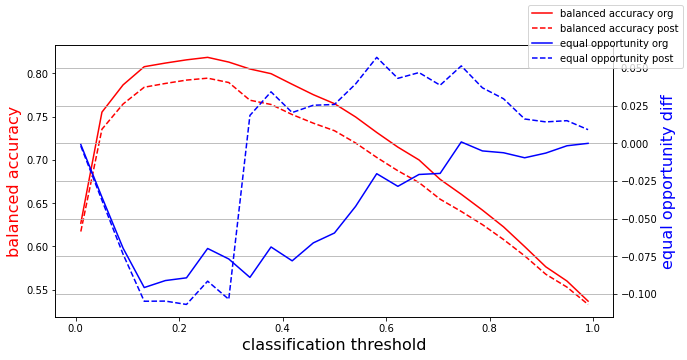

In [12]:
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots(figsize=(10,5))
ax1.plot(all_thresh, ba_acc, 'r')
ax1.plot(all_thresh, cal_ba_acc, 'r--')
ax1.set_ylabel('balanced accuracy', color='r', fontsize=16)
ax1.set_xlabel('classification threshold', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(all_thresh, eq_op_diff, 'b')
ax2.plot(all_thresh, cal_eq_op_diff, 'b--')
ax2.set_ylabel('equal opportunity diff', color='b', fontsize=16)

fig.legend(['balanced accuracy org', 'balanced accuracy post', 
            'equal opportunity org', 'equal opportunity post'])

plt.grid()